In [ ]:
from dataprovider_pypots import ForePypots
import pandas as pd
import process_edited as pce
import matplotlib.pyplot as plt
import torch

## Load Data

In [2]:
data = 'dataset/bike_sharing'
filename = f'{data}.csv'
real_df = pd.read_csv(filename)

#Metro_Traffic
#real_df["holiday"] = real_df["holiday"].fillna(0)

#Pollution Data
#real_df["pm2.5"] = real_df["pm2.5"].fillna(0)

#bike_sharing.csv 
cols = real_df.columns.to_list()
cols[1] = "date" 
real_df.columns = cols
real_df = real_df.drop(columns=["instant", "yr", "mnth"])

data_dict = ForePypots(real_df,
                 train_ratio=0.8,
                 val_ratio=0.1,
                 test_ratio=0.1,
                 seq_len=48,
                 stride=1,
                 timewindow=24)


## Train TimeAutoDiff

In [9]:
import VAE as vae
import DIFF as diff

VAE_training = 10000; diff_training = 20000; lat_dim = 6; 
real_df1 = real_df.drop(['date'], axis=1)

############ Parameter Setting ############
# pip install ipywidgets
n_epochs = VAE_training; eps = 1e-5
weight_decay = 1e-6; lr = 2e-4; hidden_size = 512; num_layers = 2; batch_size = 100
channels = 64; min_beta = 1e-5; max_beta = 0.1; emb_dim = 128; time_dim = 8; threshold = 1; device = 'cuda'

############ Auto-encoder Training ############
ds = vae.train_autoencoder(real_df1, channels, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold, min_beta, max_beta, emb_dim, time_dim, lat_dim, device, data_dict)
latent_features = ds[1]

############ Diffusion Training ############
n_epochs = diff_training; hidden_dim = 200; num_layers = 2; diffusion_steps = 100; num_classes = len(latent_features)
diff = diff.train_diffusion(latent_features, real_df1, data_dict, hidden_dim, num_layers, diffusion_steps, n_epochs, num_classes)

Output()

Output()

## Draw a sample from the trained model

In [10]:
import numpy as np
import DIFF as Diff
from pypots.nn.functional import calc_mae

target_mask_test=data_dict['target_mask_test']
target_test=data_dict['response_test']
cond_test=data_dict['cond_test']
time_info_test=data_dict['time_info_test']
parser = data_dict['parser']

# Sampling process
device = 'cuda'
diffusion_steps = 100
Batch_size, Seq_len, _ = target_test.shape
Lat_dim = lat_dim
t_grid = torch.linspace(0, 1, Seq_len).view(1, -1, 1).to(device)
samples = Diff.sample(
    t_grid.repeat(Batch_size, 1, 1),
    Batch_size,
    Seq_len,
    Lat_dim,
    diffusion_steps,
    diff,
    time_info_test,
    cond_test,
    target_mask_test.float().to(device),
)

# Process the generated data
gen_output = ds[0].decoder(samples.to(device), target_mask_test, cond_test)
_synth_data = pce.convert_to_tensor(parser, gen_output, 1, Batch_size, Seq_len)

import torch.nn.functional as F

mae = calc_mae(_synth_data.to('cpu').numpy(), target_test.to('cpu').numpy(), target_mask_test.numpy())
mse = F.mse_loss(_synth_data.to('cpu'), target_test.to('cpu'), reduction='mean').numpy()

In [11]:
print(mae,mse)

0.020836048047694726 0.0052616782


## Draw Forecasted Plot

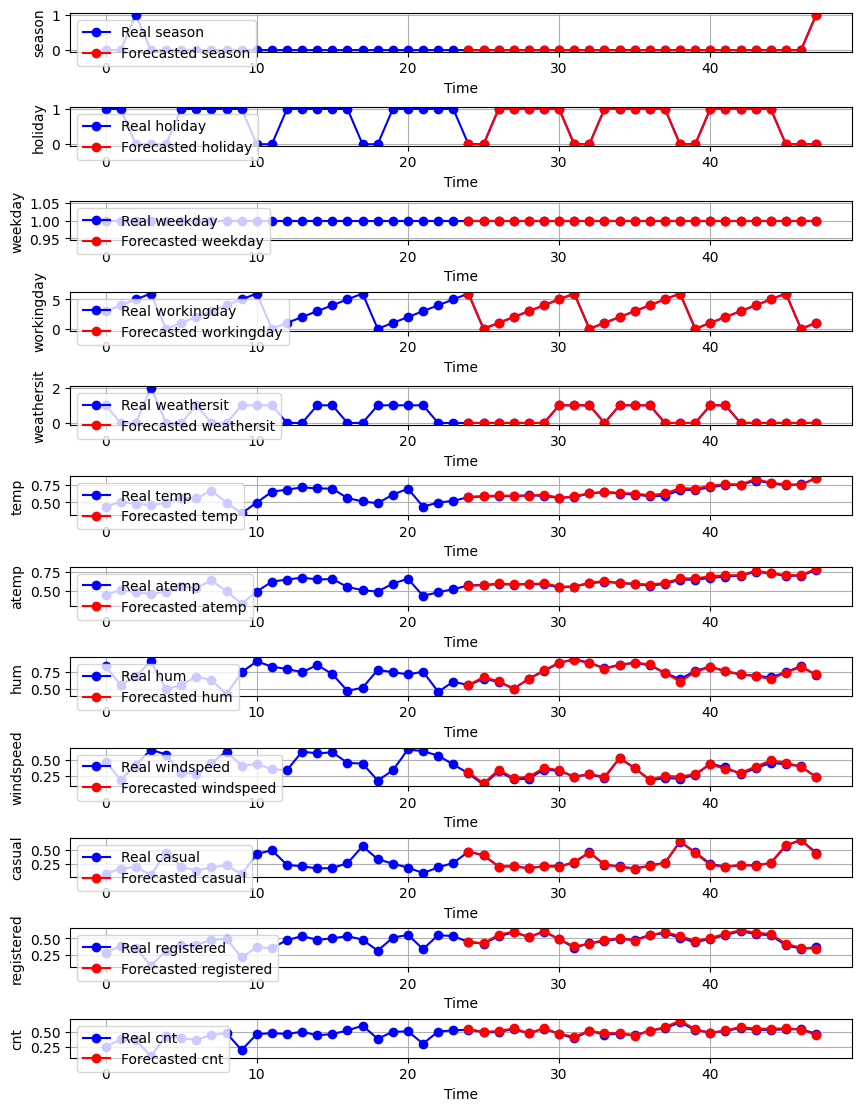

In [12]:
import matplotlib.pyplot as plt
timewindow = 24; label = 1

##################################################################################################################
entire_data = target_test + cond_test

# Create a letter-sized figure
fig, axes = plt.subplots(target_test.shape[2], 1, figsize=(8.5, 11), constrained_layout=True)  
column_name = real_df1.columns.tolist()

# Plot time series for each column
for i in range(len(column_name)):
    # Plot the real data from response_test
    axes[i].plot(entire_data[label, :, i], marker='o', linestyle='-', color='b', label=f'Real {column_name[i]}')

    # Overlay _synth_data starting from 48th temporal point
    axes[i].plot(
        range(timewindow, Seq_len),  # Temporal axis for the overlay
        _synth_data[label, timewindow:, i].cpu(),  # Use appropriate length for forecasted data
        marker='o',
        linestyle='-',
        color='r',
        label=f'Forecasted {column_name[i]}'
    )
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(f'{column_name[i]}')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

plt.show()

## Check the Latent Space for the training data

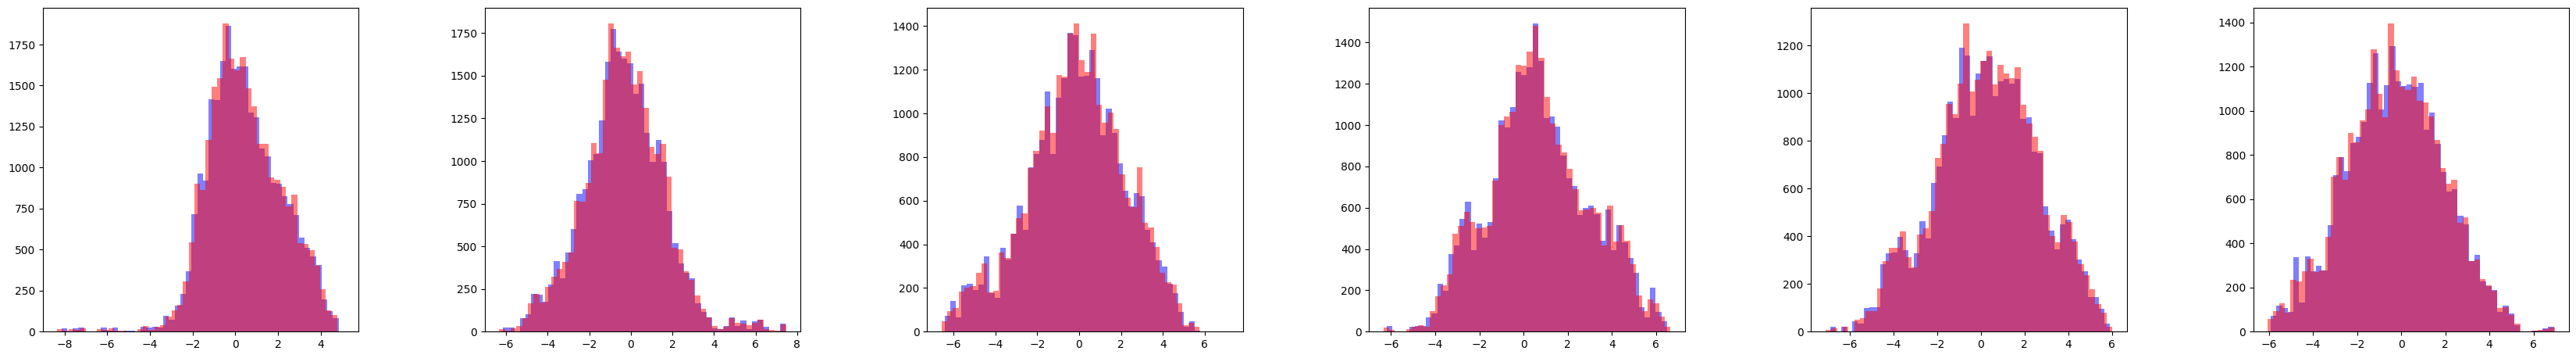

In [14]:
parser = pce.DataFrameParser().fit(real_df1, threshold)
col_name = parser.column_name()

B, L, K = latent_features.shape

target_mask_train=data_dict['target_mask_train']
target_train=data_dict['response_train']
cond_train=data_dict['cond_train']
time_info_train=data_dict['time_info_train']

# Sampling process
device = 'cuda'
diffusion_steps = 100
Batch_size, Seq_len, _ = target_train.shape
Lat_dim = lat_dim
t_grid = torch.linspace(0, 1, Seq_len).view(1, -1, 1).to(device)
samples = Diff.sample(
    t_grid.repeat(Batch_size, 1, 1),
    Batch_size,
    Seq_len,
    Lat_dim,
    diffusion_steps,
    diff,
    time_info_train,
    cond_train,
    target_mask_train.float().to(device),
)

# Process the generated data
gen_output = ds[0].decoder(samples.to(device), target_mask_train, cond_train)
_synth_data = pce.convert_to_tensor(parser, gen_output, 1, Batch_size, Seq_len)

pd_reshaped = latent_features.reshape(B * L, K)
sd_reshaped = samples.cpu().reshape(B * L, K)

real_df = pd.DataFrame(pd_reshaped.cpu().numpy())
synth_df = pd.DataFrame(sd_reshaped.cpu().numpy())

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=K, figsize=(33.1, 23.4/5))

for k in range(K):
    axes[k].hist(pd_reshaped[:, k].cpu().detach(), bins=50, color='blue', alpha=0.5, label='Real')
    axes[k].hist(sd_reshaped[:, k].cpu().detach(), bins=50, color='red', alpha=0.5, label='Synthetic')

    # Adding legends
    #axes[k].legend()
    #axes[k].set_title(col_name[k], fontsize=15)
    
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Add space between histograms
plt.show()